### Pandas vs cuDF

In [2]:
!nvidia-smi

Sat Dec 30 11:33:27 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

  Using cached cupy_cuda12x-12.3.0-cp310-cp310-manylinux2014_x86_64.whl (81.8 MB)

        ***********************************************************************
        The pip install of RAPIDS is complete.
        
        Please do not run any further installation from the conda based installation methods, as they may cause issues!
        
        Please ensure that you're pulling from the git repo to remain updated with the latest working install scripts.

        Troubleshooting:
            - If there is an installation failure, please check back on RAPIDSAI owned templates/notebooks to see how to update your personal files. 
            - If an installation failure persists when using the latest script, please make an issue on https://github.com/rapidsai-community/rapidsai-csp-utils
        ***********************************************************************
        


In [4]:
import re
import pandas as pd
import cudf
import timeit

In [5]:
read_csv = []
reverse = []
concat = []
drop = []
merge = []

In [6]:
def display_time(time_took, message):
    print(f"{message}: {time_took:.6f}s")

In [7]:
def get_read_csv(filename, method='cudf'):
    column_names = ['column 1', 'column 2']
    if method == 'df':
        return pd.read_csv(filename, sep='\t', header=None,
                           names=column_names, dtype='unicode')
    return cudf.read_csv(filename, sep='\t', header=None,
                         names=column_names)

In [8]:
def get_reverse(relation):
    column_names = ['column 1', 'column 2']
    reverse_relation = relation[relation.columns[::-1]]
    reverse_relation.columns = column_names
    return reverse_relation

In [9]:
def get_merge(relation_1, relation_2):
    column_names = ['column 1', 'column 2']
    return relation_1.merge(relation_2, on=column_names[0],
                            how="inner",
                            suffixes=('_relation_1', '_relation_2'))

In [10]:
def get_drop(result):
    column_names = ['column 1', 'column 2']
    temp = result.drop([column_names[0]], axis=1).drop_duplicates()
    temp.columns = column_names
    return temp

In [11]:
def get_concat(relation_1, relation_2, method='cudf'):
    if method == 'df':
        return pd.concat([relation_1, relation_2], ignore_index=True)
    return cudf.concat([relation_1, relation_2], ignore_index=True)

In [12]:
dataset = "./roadrail.txt"
repeat = 10

In [13]:
cudf_csv_read = timeit.timeit('get_read_csv(dataset)',
                                  number=repeat,
                                  globals=globals())
display_time(cudf_csv_read, "CUDF read csv")
relation_1_cudf = get_read_csv(dataset)
read_csv.append(cudf_csv_read)

CUDF read csv: 0.922596s


In [14]:
method = 'df'
pandas_csv_read = timeit.timeit('get_read_csv(dataset, method)',
                                number=repeat,
                                globals=globals())
display_time(pandas_csv_read, "Pandas read csv")
relation_1_pd = get_read_csv(dataset, method)
read_csv.append(pandas_csv_read)

Pandas read csv: 26.842199s


In [15]:
cudf_reverse_df = timeit.timeit('get_reverse(relation_1_cudf)',
                                    number=repeat,
                                    globals=globals())
display_time(cudf_reverse_df, "CUDF reverse dataframe")
relation_2_cudf = get_reverse(relation_1_cudf)
reverse.append(cudf_reverse_df)

CUDF reverse dataframe: 0.008096s


In [16]:
pandas_reverse_df = timeit.timeit('get_reverse(relation_1_pd)',
                                      number=repeat,
                                      globals=globals())
display_time(pandas_reverse_df, "Pandas reverse dataframe")
relation_2_pd = get_reverse(relation_1_pd)
reverse.append(pandas_reverse_df)

Pandas reverse dataframe: 2.305187s


In [17]:
cudf_merge_df = timeit.timeit('get_merge(relation_1_cudf, relation_2_cudf)',
                                  number=repeat,
                                  globals=globals())
display_time(cudf_merge_df, "CUDF merge dataframes")
result_cudf = get_merge(relation_1_cudf, relation_2_cudf)
merge.append(cudf_merge_df)

CUDF merge dataframes: 0.893337s


In [18]:
pandas_merge_df = timeit.timeit('get_merge(relation_1_pd, relation_2_pd)',
                                    number=repeat,
                                    globals=globals())
display_time(pandas_merge_df, "Pandas merge dataframes")
result_pd = get_merge(relation_1_pd, relation_2_pd)
merge.append(pandas_merge_df)

Pandas merge dataframes: 59.117822s


In [19]:
cudf_drop = timeit.timeit('get_drop(result_cudf)',
                              number=repeat,
                              globals=globals())
display_time(cudf_drop, "CUDF drop rows")
result = get_drop(result_cudf)
drop.append(cudf_drop)

CUDF drop rows: 1.155152s


In [20]:
pandas_drop = timeit.timeit('get_drop(result_pd)',
                            number=repeat,
                            globals=globals())
display_time(pandas_drop, "Pandas drop rows")
result = get_drop(result_pd)
drop.append(pandas_drop)

Pandas drop rows: 98.584534s


In [21]:
cudf_concat = timeit.timeit('get_concat(relation_1_cudf, relation_2_cudf)',
                            number=repeat,
                            globals=globals())
display_time(cudf_concat, "CUDF concat relations")
result = get_concat(relation_1_cudf, relation_2_cudf)
print(f"CUDF final result length: {len(result)}")

pandas_concat = timeit.timeit('get_concat(relation_1_pd, relation_2_pd, method)',
                              number=repeat,
                              globals=globals())
display_time(pandas_concat, "Pandas concat relations")
result = get_concat(relation_1_pd, relation_2_pd, method)
print(f"Pandas final result length: {len(result)}")
concat.append(cudf_concat)
concat.append(pandas_concat)

CUDF concat relations: 0.092265s
CUDF final result length: 11066430
Pandas concat relations: 4.067704s
Pandas final result length: 11066430


In [22]:
import matplotlib.pyplot as plt

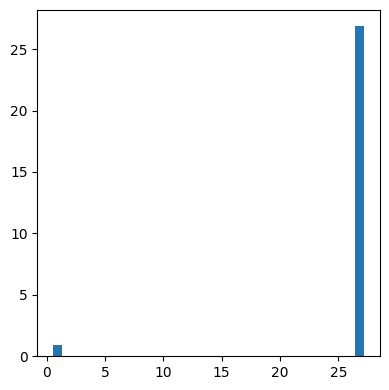

In [23]:
plt.rcParams["figure.figsize"] = [4, 4]
plt.rcParams["figure.autolayout"] = True
plt.bar(read_csv, read_csv)
plt.show()

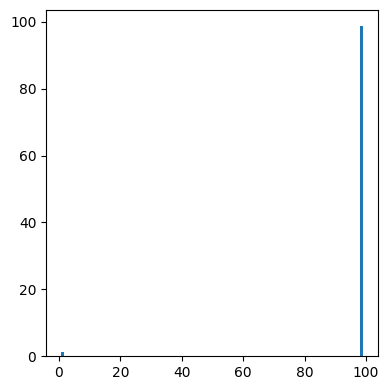

In [24]:
plt.rcParams["figure.figsize"] = [4, 4]
plt.rcParams["figure.autolayout"] = True
plt.bar(drop, drop)
plt.show()

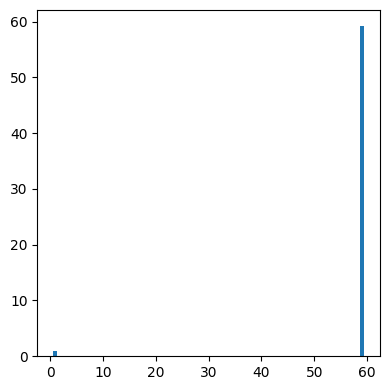

In [25]:
plt.rcParams["figure.figsize"] = [4, 4]
plt.rcParams["figure.autolayout"] = True
plt.bar(merge, merge)
plt.show()

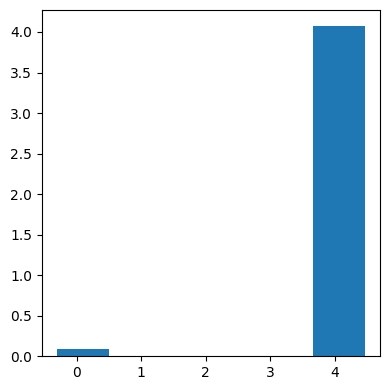

In [26]:
plt.rcParams["figure.figsize"] = [4, 4]
plt.rcParams["figure.autolayout"] = True
plt.bar(concat, concat)
plt.show()

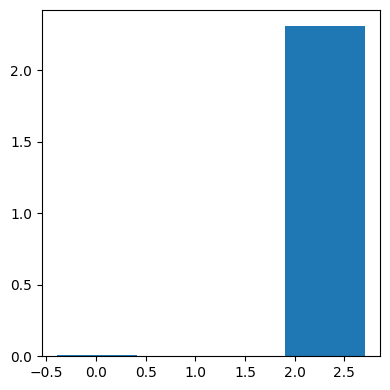

In [27]:
plt.rcParams["figure.figsize"] = [4, 4]
plt.rcParams["figure.autolayout"] = True
plt.bar(reverse, reverse)
plt.show()

In [28]:
print(f"CUDF is {read_csv[1]/read_csv[0]} faster than Pandas while reading csv")

CUDF is 29.09421680290118 faster than Pandas while reading csv


In [29]:
print(f"CUDF is {reverse[1]/reverse[0]} faster than Pandas while reversing csv")

CUDF is 284.7426929383888 faster than Pandas while reversing csv


In [30]:
print(f"CUDF is {merge[1]/merge[0]} faster than Pandas while merging df")

CUDF is 66.17639578858014 faster than Pandas while merging df


In [31]:
print(f"CUDF is {concat[1]/concat[0]} faster than Pandas while concat df")

CUDF is 44.087137614728945 faster than Pandas while concat df


In [32]:
print(f"CUDF is {drop[1]/drop[0]} faster than Pandas while dropping records")

CUDF is 85.3433425161216 faster than Pandas while dropping records


In [ ]:
!wget https://snap.stanford.edu/data/roadNet-CA.txt.gz

In [ ]:
import pandas as pd

In [ ]:
new_df = pd.read_csv("roadNet-CA.txt", sep='\t', skiprows=3)

In [ ]:
new_df.rename(columns = {'# FromNodeId':'column 1', 'ToNodeId': 'column 2'}, inplace = True)

In [ ]:
new_df.to_csv("roadrail.txt", index=False, sep='\t')